In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words[:]:
    # print(w)
    context = [0] * block_size

    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
C = torch.randn((27, 2))  # embed 27 characters in a 2-dim vector space
# essentially, if there is a 2-dim space, then each one of the 27 chars can be represented as a point in that space.

In [7]:
emb = C[X]  # embeddings of individual starting data points

In [11]:
# construct hidden layer.
# 6 - inputs cuz 3 * 2 -> 3 of 2-dim embeddings
W1 = torch.randn((6, 100))  # 100 neurons for the layer
b1 = torch.randn(100)

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [19]:
h.shape

torch.Size([32, 100])

In [21]:
# output layer

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [22]:
logits = h @ W2 + b2

In [24]:
counts = logits.exp()

In [25]:
prob = counts / counts.sum(1, keepdims=True)

In [26]:
prob.shape

torch.Size([32, 27])

In [29]:
loss = -prob[torch.arange(32), Y].log().mean()

In [30]:
loss

tensor(14.1654)

In [31]:
# rearrange

In [34]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [54]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)  # embed 27 characters in a 2-dim vector space
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [55]:
sum(p.nelement() for p in parameters)

3481

In [56]:
for p in parameters:
    p.requires_grad = True

In [57]:
# learning rate exponent
lre = torch.linspace(-3, 0, 1000)  # between .001 & 1
lrs = 10**lre

In [66]:
# forward pass
lri = []
lossi = []

for i in range(10000):
    # mini-batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = prob[torch.arange(32, Y)]

    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.3621671199798584


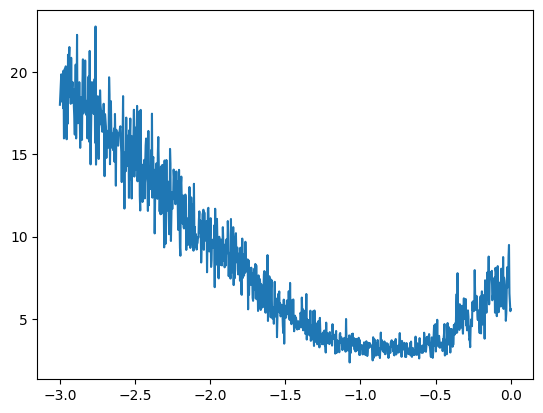

In [48]:
# essentially explore a plot of loss stability across different learning rates
# and appropriate determine the optimal.
# in this case the optimal rate is looking to be 10^-1 = 0.1

plt.plot(lri, lossi)

In [67]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2539, grad_fn=<NllLossBackward0>)